In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [159]:
fear_df=pd.read_csv('../data/raw/fear_greed_index.csv')
print("=== FEAR & GREED DATASET ===")
print(f"Shape: {fear_df.shape}")
fear_df.head()

=== FEAR & GREED DATASET ===
Shape: (2644, 4)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [160]:
# Load Historical Trading dataset
trading_df = pd.read_csv('../data/raw/historical_data.csv')
print(f"\n=== TRADING DATASET ===")
print(f"Shape: {trading_df.shape}")
trading_df.head()


=== TRADING DATASET ===
Shape: (211224, 16)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [161]:
#Step 1:  Preprocessing dates and aggregating trading data daily per trader

# Converting 'date' column in Fear & Greed dataset to datetime
fear_df['date'] = pd.to_datetime(fear_df['date'])

# Converting 'Timestamp IST' to datetime in trading dataset and extract date
trading_df['Timestamp IST'] = pd.to_datetime(trading_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
trading_df['date'] = trading_df['Timestamp IST'].dt.date

# Converting trading date to datetime for proper merging
trading_df['date'] = pd.to_datetime(trading_df['date'])

# Aggregating daily trader performance
daily_trader_perf = trading_df.groupby(['date', 'Account']).agg({
    'Closed PnL': 'sum',
    'Size USD': 'sum',
    'Fee': 'sum',
    'Transaction Hash': 'count'
}).rename(columns={
    'Closed PnL': 'Daily_PnL',
    'Size USD': 'Daily_Volume',
    'Fee': 'Daily_Fees',
    'Transaction Hash': 'Daily_Trades'
}).reset_index()

print("=== DAILY TRADER PERFORMANCE AGGREGATED ===")
print(f"Shape: {daily_trader_perf.shape}")
print(f"Date range: {daily_trader_perf['date'].min()} to {daily_trader_perf['date'].max()}")
print(f"Unique traders: {daily_trader_perf['Account'].nunique()}")
print("\nFirst 5 rows:")
daily_trader_perf.head()


=== DAILY TRADER PERFORMANCE AGGREGATED ===
Shape: (2341, 6)
Date range: 2023-05-01 00:00:00 to 2025-05-01 00:00:00
Unique traders: 32

First 5 rows:


,date,Account,Daily_PnL,Daily_Volume,Daily_Fees,Daily_Trades
0,2023-05-01,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000,477.00,0.000000,3
1,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0.000000,50005.83,12.501455,9
2,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-205.434737,113203.35,28.300831,11
3,2023-12-15,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-24.632034,10609.95,2.652489,2
4,2023-12-16,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0.000000,15348.77,3.837189,3


In [162]:
print(f"\n=== AGGREGATION SUMMARY ===")
print(f"Original transactions: 2,11,224 → Daily records: {len(daily_trader_perf)}")
print(f"Average daily PnL: ${daily_trader_perf['Daily_PnL'].mean():.2f}")
print(f"Average daily volume: ${daily_trader_perf['Daily_Volume'].mean():,.2f}")


=== AGGREGATION SUMMARY ===
Original transactions: 2,11,224 → Daily records: 2341
Average daily PnL: $4398.53
Average daily volume: $508,837.01


In [163]:
# Step 2: Aggregating daily trader-coin performance (incorporating coin analysis)

# Aggregating at daily trader-coin level this time and not on just trader level
daily_trader_coin_perf = trading_df.groupby(['date', 'Account', 'Coin']).agg({
    'Closed PnL': 'sum',
    'Size USD': 'sum',
    'Fee': 'sum',
    'Transaction Hash': 'count'
}).rename(columns={
    'Closed PnL': 'Daily_PnL',
    'Size USD': 'Daily_Volume',
    'Fee': 'Daily_Fees',
    'Transaction Hash': 'Daily_Trades'
}).reset_index()

print("=== COIN-LEVEL DAILY AGGREGATION ===")
print(f"Shape: {daily_trader_coin_perf.shape}")
print(f"Date range: {daily_trader_coin_perf['date'].min()} to {daily_trader_coin_perf['date'].max()}")
print(f"Unique traders: {daily_trader_coin_perf['Account'].nunique()}")
print(f"Unique coins: {daily_trader_coin_perf['Coin'].nunique()}")
print("\nTop 10 most traded coins:")
print(daily_trader_coin_perf['Coin'].value_counts().head(10))

# Merge with Fear & Greed sentiment data
combined_coin_df = daily_trader_coin_perf.merge(
    fear_df[['date', 'value', 'classification']], 
    on='date', 
    how='inner'
)


=== COIN-LEVEL DAILY AGGREGATION ===
Shape: (7121, 7)
Date range: 2023-05-01 00:00:00 to 2025-05-01 00:00:00
Unique traders: 32
Unique coins: 246

Top 10 most traded coins:
Coin
BTC          667
@107         575
HYPE         503
ETH          476
SOL          322
FARTCOIN     204
SUI          201
PURR/USDC    183
XRP          146
WLD          119
Name: count, dtype: int64


In [164]:
print(f"\n=== MERGED COIN-SENTIMENT DATASET ===")
print(f"Shape: {combined_coin_df.shape}")
print(f"Records per sentiment class:")
print(combined_coin_df['classification'].value_counts())


=== MERGED COIN-SENTIMENT DATASET ===
Shape: (7120, 9)
Records per sentiment class:
classification
Greed            2135
Extreme Greed    1972
Fear             1474
Neutral          1078
Extreme Fear      461
Name: count, dtype: int64


In [165]:
print(f"\nFirst 5 rows:")
combined_coin_df.head()


First 5 rows:


,date,Account,Coin,Daily_PnL,Daily_Volume,Daily_Fees,Daily_Trades,value,classification
0,2023-05-01,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,ETH,0.000000,477.00,0.000000,3,63,Greed
1,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,BTC,0.000000,24998.62,6.249655,2,75,Extreme Greed
2,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,0.000000,25007.21,6.251800,7,75,Extreme Greed
3,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,AAVE,76.369902,51839.62,12.959901,6,72,Greed
4,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,BTC,-527.233130,25525.84,6.381460,2,72,Greed


In [166]:
# Step 3:Creating trader clustering from daily performance data considering the coins too!
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Aggregate total trader performance metrics from coin-level data
trader_perf_summary = daily_trader_coin_perf.groupby('Account').agg({
    'Daily_PnL': 'sum',
    'Daily_Volume': 'sum', 
    'Daily_Trades': 'sum',
    'Daily_Fees': 'sum'
}).rename(columns={
    'Daily_PnL': 'Total_PnL',
    'Daily_Volume': 'Total_Volume',
    'Daily_Trades': 'Total_Trades',
    'Daily_Fees': 'Total_Fees'
})
# Calculate additional performance metrics
trader_perf_summary['Avg_PnL_per_Trade'] = trader_perf_summary['Total_PnL'] / trader_perf_summary['Total_Trades']
trader_perf_summary['Net_PnL'] = trader_perf_summary['Total_PnL'] - trader_perf_summary['Total_Fees']
trader_perf_summary['PnL_per_Dollar_Volume'] = trader_perf_summary['Total_PnL'] / trader_perf_summary['Total_Volume']


In [167]:
# Handle infinite and missing values even though there are no infinite and empty values just an extra caution
trader_perf_summary = trader_perf_summary.replace([np.inf, -np.inf], np.nan).dropna()

print("=== TRADER PERFORMANCE SUMMARY FOR CLUSTERING ===")
print(f"Shape: {trader_perf_summary.shape}")
trader_perf_summary.head()

=== TRADER PERFORMANCE SUMMARY FOR CLUSTERING ===
Shape: (32, 7)


,Total_PnL,Total_Volume,Total_Trades,Total_Fees,Avg_PnL_per_Trade,Net_PnL,PnL_per_Dollar_Volume
Account,,,,,,,
0x083384f897ee0f19899168e3b1bec365f52a9012,1.600230e+06,61697263.97,3818,7405.312304,419.127768,1.592825e+06,0.025937
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,4.788532e+04,12035487.66,7280,2729.837889,6.577654,4.515548e+04,0.003979
0x271b280974205ca63b716753467d5a371de622ab,-7.043619e+04,33873440.42,3809,9280.982850,-18.492043,-7.971717e+04,-0.002079
0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1.324648e+05,6757022.10,13311,2218.367366,9.951530,1.302464e+05,0.019604
0x2c229d22b100a7beb69122eed721cee9b24011dd,1.686580e+05,10166880.20,3239,3108.196722,52.071011,1.655498e+05,0.016589


In [168]:
# Prepare features for clustering
clustering_features = trader_perf_summary[['Total_Trades', 'Total_PnL', 'Total_Volume', 'Avg_PnL_per_Trade', 'PnL_per_Dollar_Volume']]

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(clustering_features)

# Apply K-means clustering with k=4 <-- we calculated this in 02_History_data_EDA.ipynb
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(features_scaled)

# Add cluster labels
trader_perf_summary['Cluster'] = clusters

print(f"\n=== CLUSTERING RESULTS ===")
print("Cluster distribution:")
print(trader_perf_summary['Cluster'].value_counts().sort_index())


=== CLUSTERING RESULTS ===
Cluster distribution:
Cluster
0     4
1    21
2     6
3     1
Name: count, dtype: int64


In [169]:
trader_perf_summary

,Total_PnL,Total_Volume,Total_Trades,Total_Fees,Avg_PnL_per_Trade,Net_PnL,PnL_per_Dollar_Volume,Cluster
Account,,,,,,,,
0x083384f897ee0f19899168e3b1bec365f52a9012,1.600230e+06,6.169726e+07,3818,7405.312304,419.127768,1.592825e+06,0.025937,0
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,4.788532e+04,1.203549e+07,7280,2729.837889,6.577654,4.515548e+04,0.003979,1
0x271b280974205ca63b716753467d5a371de622ab,-7.043619e+04,3.387344e+07,3809,9280.982850,-18.492043,-7.971717e+04,-0.002079,1
0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1.324648e+05,6.757022e+06,13311,2218.367366,9.951530,1.302464e+05,0.019604,1
0x2c229d22b100a7beb69122eed721cee9b24011dd,1.686580e+05,1.016688e+07,3239,3108.196722,52.071011,1.655498e+05,0.016589,1
0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,-3.120360e+04,1.409902e+06,815,147.074763,-38.286626,-3.135067e+04,-0.022132,1
0x39cef799f8b69da1995852eea189df24eb5cae3c,1.445692e+04,1.719338e+07,3589,1458.657126,4.028119,1.299826e+04,0.000841,1
0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6,5.349625e+04,1.143896e+06,332,176.274176,161.133275,5.331997e+04,0.046767,1
0x420ab45e0bd8863569a5efbb9c05d91f40624641,1.995056e+05,1.987528e+06,383,267.967089,520.902331,1.992376e+05,0.100379,2


In [170]:
# Analyze cluster characteristics
cluster_summary = trader_perf_summary.groupby('Cluster').agg({
    'Total_Trades': ['mean', 'median'],
    'Total_PnL': ['mean', 'median'],
    'Total_Volume': ['mean', 'median'],
    'Avg_PnL_per_Trade': ['mean', 'median']
}).round(2)

print(f"\n=== CLUSTER CHARACTERISTICS ===")
cluster_summary


=== CLUSTER CHARACTERISTICS ===


Total_Trades            Total_PnL              Total_Volume  \
                mean   median        mean      median          mean   
Cluster                                                               
0           19981.75  17962.5  1379964.19  1270196.81  6.509624e+07   
1            5382.33   3809.0   109842.26    65513.66  2.327889e+07   
2            1005.33   1106.0   271665.37   301258.55  3.511525e+06   
3           12236.00  12236.0   840422.56   840422.56  4.208766e+08   

                      Avg_PnL_per_Trade          
               median              mean  median  
Cluster                                          
0        6.486680e+07            157.44   94.92  
1        1.199917e+07             34.85   12.13  
2        2.476818e+06            282.62  275.93  
3        4.208766e+08             68.68   68.68

In [171]:
# Step 5: Merge cluster information with coin-sentiment dataset
combined_final_df = combined_coin_df.merge(
    trader_perf_summary[['Cluster']], 
    left_on='Account', 
    right_index=True, 
    how='left'
)

print("=== FINAL COMBINED DATASET ===")
print(f"Shape: {combined_final_df.shape}")
print(f"Cluster distribution in daily records:")
print(combined_final_df['Cluster'].value_counts())

# Core Analysis: Performance by Sentiment and Cluster
performance_by_sentiment_cluster = combined_final_df.groupby(['classification', 'Cluster']).agg({
    'Daily_PnL': ['mean', 'median', 'count'],
    'Daily_Volume': 'mean',
    'Daily_Trades': 'mean'
}).round(2)


=== FINAL COMBINED DATASET ===
Shape: (7120, 10)
Cluster distribution in daily records:
Cluster
1    5884
0     839
2     345
3      52
Name: count, dtype: int64


In [172]:
print(f"\n=== PERFORMANCE BY SENTIMENT & CLUSTER ===")
performance_by_sentiment_cluster


=== PERFORMANCE BY SENTIMENT & CLUSTER ===


Daily_PnL                 Daily_Volume Daily_Trades
                            mean    median count         mean         mean
classification Cluster                                                    
Extreme Fear   0         9282.74    551.12    46    652515.63       226.04
               1          376.84      0.00   371    206575.43        25.98
               2         6241.48      0.00    39    115185.32        26.10
               3       -14224.36   3131.84     5    667365.84        69.20
Extreme Greed  0        12252.65    123.76   126    262740.21        73.90
               1          514.70     10.47  1793     48653.99        16.50
               2         5071.05      0.00    49     69305.23        17.86
               3            0.00      0.00     4    181833.02        55.75
Fear           0         9758.50     28.52   193    493187.19       156.07
               1          825.68      4.48  1126    141432.75        21.54
               2         1350.22      0.00   131     29002.65        11.30
               3        15298.59   5570.44    24   9378626.39       249.21
Greed          0         3336.02      0.00   316    198018.83        43.69
               1           83.97      2.88  1716     55845.19        18.10
               2         8391.59      0.00    94     87009.50        24.15
               3        18116.41   1656.21     9  13555477.68       352.11
Neutral        0         3869.91      0.00   158    250031.11       103.11
               1          193.86      5.32   878     79609.37        21.06
               2         4060.40      0.00    32     34814.24        11.97
               3        38133.05  15187.97    10   6972606.26       251.70

In [173]:
# Create pivot table for clear sentiment-cluster matrix
sentiment_cluster_pivot = combined_final_df.pivot_table(
    values='Daily_PnL',
    index='classification',
    columns='Cluster',
    aggfunc='mean'
).round(2)

print(f"\n=== AVERAGE DAILY PnL BY SENTIMENT & CLUSTER ===")
print(sentiment_cluster_pivot)


=== AVERAGE DAILY PnL BY SENTIMENT & CLUSTER ===
Cluster                0       1        2         3
classification                                     
Extreme Fear     9282.74  376.84  6241.48 -14224.36
Extreme Greed   12252.65  514.70  5071.05      0.00
Fear             9758.50  825.68  1350.22  15298.59
Greed            3336.02   83.97  8391.59  18116.41
Neutral          3869.91  193.86  4060.40  38133.05


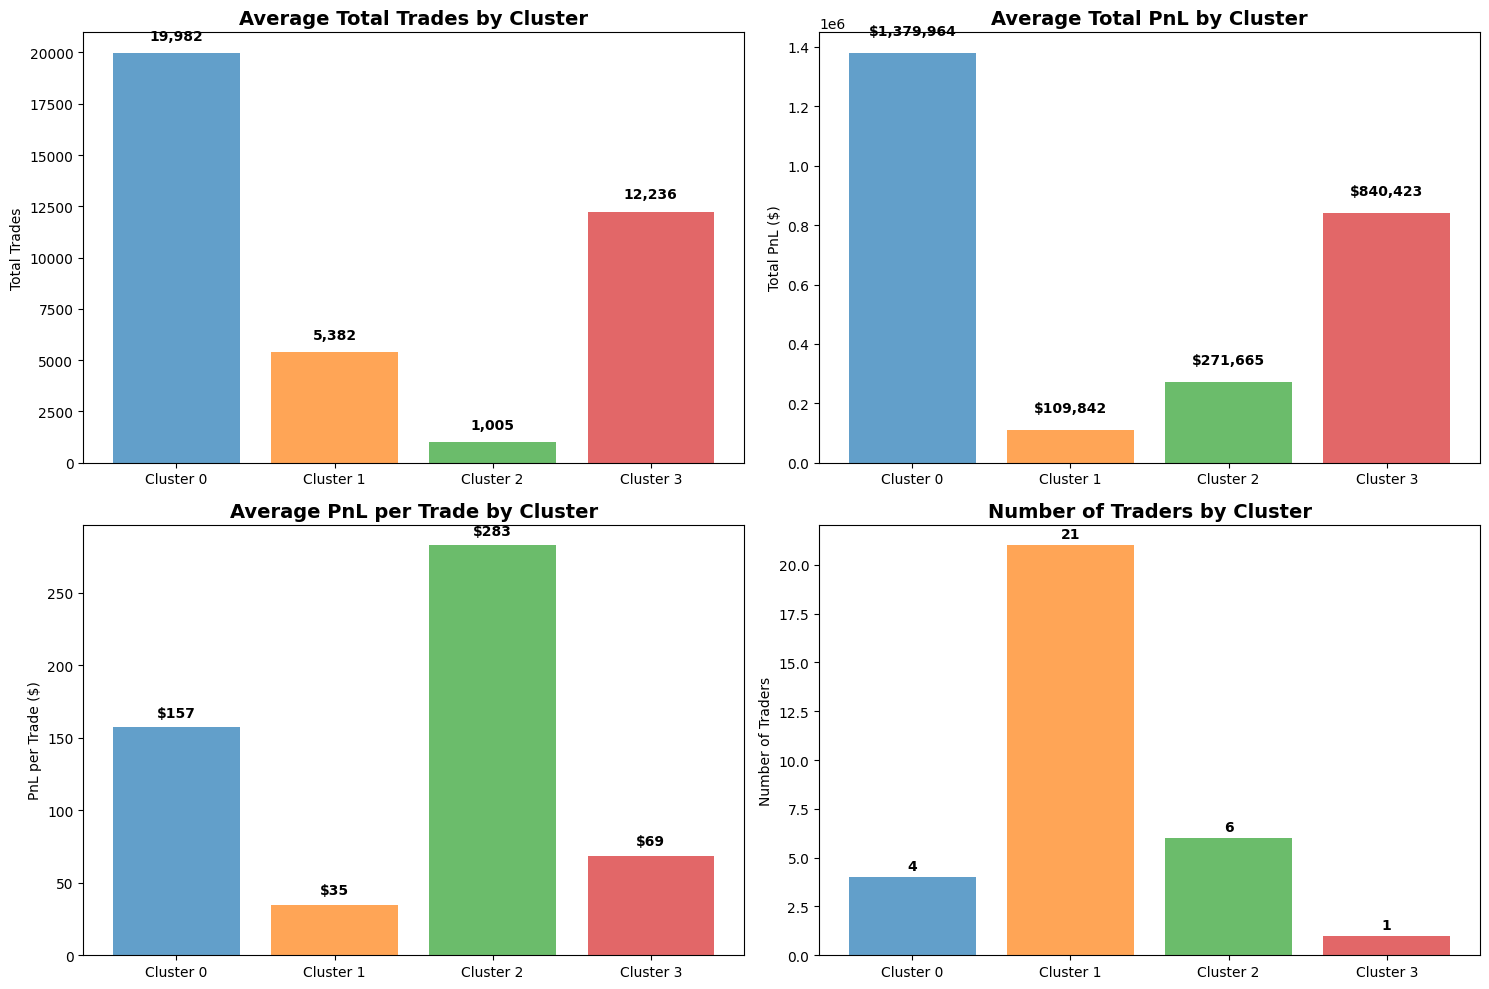

In [ ]:
# Extract cluster data from your results
cluster_data = {
    'Cluster 0': {'Total_Trades': 19981.75, 'Total_PnL': 1379964.19, 'Total_Volume': 65096244, 'Avg_PnL_per_Trade': 157.44, 'Count': 4},
    'Cluster 1': {'Total_Trades': 5382.33, 'Total_PnL': 109842.26, 'Total_Volume': 23278893, 'Avg_PnL_per_Trade': 34.85, 'Count': 21}, 
    'Cluster 2': {'Total_Trades': 1005.33, 'Total_PnL': 271665.37, 'Total_Volume': 3511525, 'Avg_PnL_per_Trade': 282.62, 'Count': 6},
    'Cluster 3': {'Total_Trades': 12236, 'Total_PnL': 840422.56, 'Total_Volume': 42087656, 'Avg_PnL_per_Trade': 68.68, 'Count': 1}
}

# Create grouped bar chart
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

clusters = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# 1. Total Trades by Cluster
trades_data = [cluster_data[c]['Total_Trades'] for c in clusters]
ax1.bar(clusters, trades_data, color=colors, alpha=0.7)
ax1.set_title('Average Total Trades by Cluster', fontsize=14, fontweight='bold')
ax1.set_ylabel('Total Trades')
for i, v in enumerate(trades_data):
    ax1.text(i, v + 500, f'{v:,.0f}', ha='center', va='bottom', fontweight='bold')

# 2. Total PnL by Cluster  
pnl_data = [cluster_data[c]['Total_PnL'] for c in clusters]
ax2.bar(clusters, pnl_data, color=colors, alpha=0.7)
ax2.set_title('Average Total PnL by Cluster', fontsize=14, fontweight='bold')
ax2.set_ylabel('Total PnL ($)')
for i, v in enumerate(pnl_data):
    ax2.text(i, v + 50000, f'${v:,.0f}', ha='center', va='bottom', fontweight='bold')

# 3. Average PnL per Trade by Cluster
avg_pnl_data = [cluster_data[c]['Avg_PnL_per_Trade'] for c in clusters]
ax3.bar(clusters, avg_pnl_data, color=colors, alpha=0.7)
ax3.set_title('Average PnL per Trade by Cluster', fontsize=14, fontweight='bold')
ax3.set_ylabel('PnL per Trade ($)')
for i, v in enumerate(avg_pnl_data):
    ax3.text(i, v + 5, f'${v:.0f}', ha='center', va='bottom', fontweight='bold')

# 4. Cluster Size (Number of Traders)
count_data = [cluster_data[c]['Count'] for c in clusters]
ax4.bar(clusters, count_data, color=colors, alpha=0.7)
ax4.set_title('Number of Traders by Cluster', fontsize=14, fontweight='bold')
ax4.set_ylabel('Number of Traders')
for i, v in enumerate(count_data):
    ax4.text(i, v + 0.2, f'{v}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


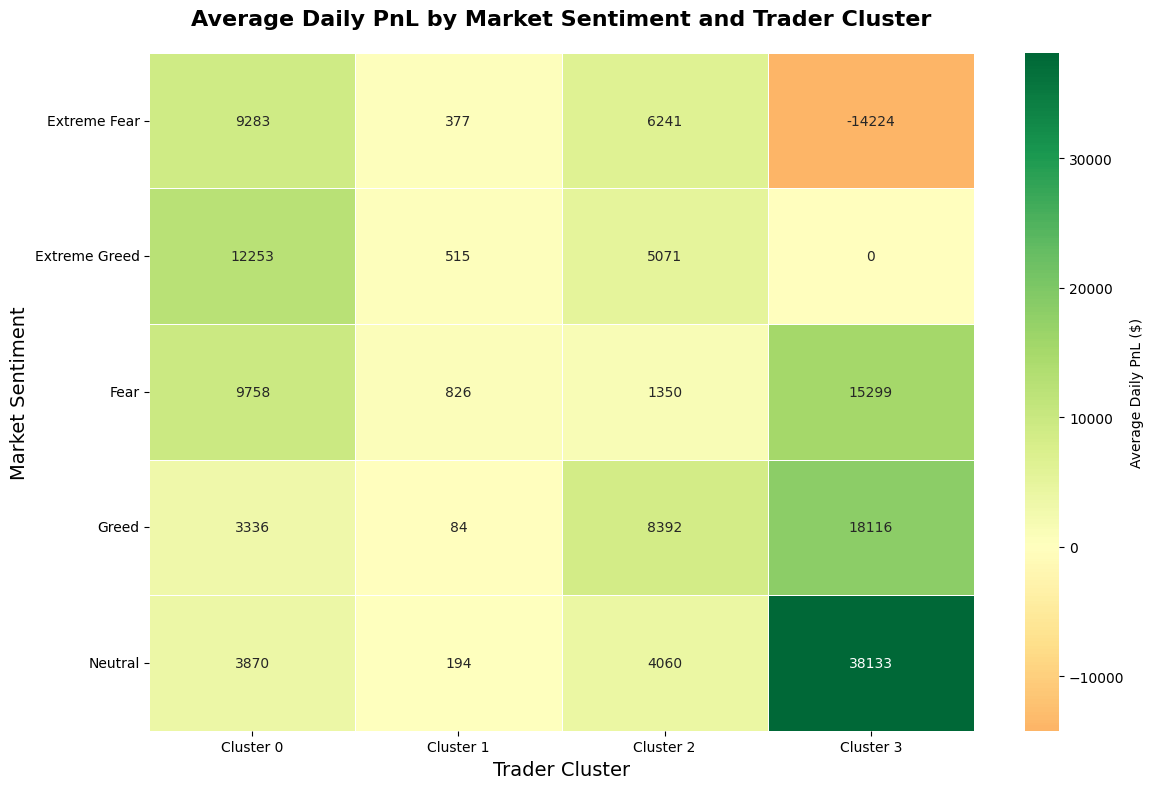

In [ ]:
import pandas as pd
import seaborn as sns

# Create the pivot table from your results
sentiment_performance_data = {
    'Extreme Fear': [9282.74, 376.84, 6241.48, -14224.36],
    'Extreme Greed': [12252.65, 514.70, 5071.05, 0.00],
    'Fear': [9758.50, 825.68, 1350.22, 15298.59],
    'Greed': [3336.02, 83.97, 8391.59, 18116.41], 
    'Neutral': [3869.91, 193.86, 4060.40, 38133.05]
}

# Create DataFrame
sentiment_df = pd.DataFrame(sentiment_performance_data, 
                        index=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])

# Create heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(sentiment_df.T, 
                    annot=True, 
                    fmt='.0f',
                    cmap='RdYlGn',
                    center=0,
                    cbar_kws={'label': 'Average Daily PnL ($)'},
                    linewidths=0.5,
                    linecolor='white')

plt.title('Average Daily PnL by Market Sentiment and Trader Cluster', 
        fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Trader Cluster', fontsize=14)
plt.ylabel('Market Sentiment', fontsize=14)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


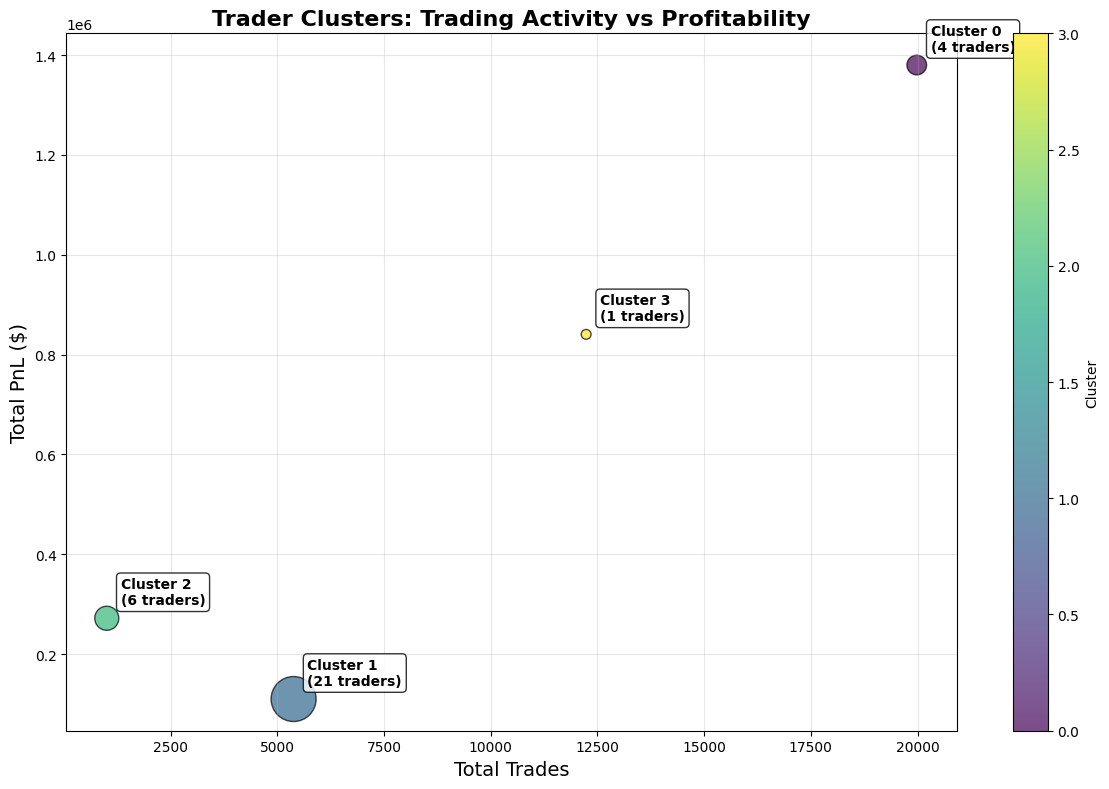

In [ ]:
# Extract data for scatter plot
scatter_data = []
for cluster, data in cluster_data.items():
    cluster_num = int(cluster.split()[1])
    scatter_data.append([data['Total_Trades'], data['Total_PnL'], cluster_num, data['Count']])

scatter_df = pd.DataFrame(scatter_data, columns=['Total_Trades', 'Total_PnL', 'Cluster', 'Trader_Count'])

plt.figure(figsize=(12, 8))
scatter = plt.scatter(scatter_df['Total_Trades'], 
                    scatter_df['Total_PnL'],
                    c=scatter_df['Cluster'],
                    s=scatter_df['Trader_Count'] * 50,  # Size based on number of traders
                    cmap='viridis',
                    alpha=0.7,
                    edgecolors='black',
                    linewidth=1)

plt.xlabel('Total Trades', fontsize=14)
plt.ylabel('Total PnL ($)', fontsize=14)
plt.title('Trader Clusters: Trading Activity vs Profitability', fontsize=16, fontweight='bold')

# Add cluster labels
for i, row in scatter_df.iterrows():
    plt.annotate(f'Cluster {int(row["Cluster"])}\n({int(row["Trader_Count"])} traders)', 
                (row['Total_Trades'], row['Total_PnL']),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
                fontsize=10, fontweight='bold')

plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
#Creating Cluster Archetype Summary

cluster_archetypes = {
    'Cluster 0': {'Name': 'Hyperactive Professionals', 'Description': 'High-frequency traders with consistent profits'},
    'Cluster 1': {'Name': 'Active Retail', 'Description': 'Moderate activity, steady performance, largest group'},  
    'Cluster 2': {'Name': 'Efficient Specialists', 'Description': 'Low frequency, highest efficiency, strategic traders'},
    'Cluster 3': {'Name': 'The Whale', 'Description': 'Single massive trader, extreme volume, variable performance'}
}

#Printing archetype summary
print("=== TRADER ARCHETYPE SUMMARY ===")
for cluster, info in cluster_archetypes.items():
    data = cluster_data[cluster]
    print(f"\n{cluster}: {info['Name']}")
    print(f"Description: {info['Description']}")
    print(f"Traders: {data['Count']}")
    print(f"Avg Trades: {data['Total_Trades']:,.0f}")
    print(f"Avg PnL: ${data['Total_PnL']:,.0f}")
    print(f"Efficiency: ${data['Avg_PnL_per_Trade']:.0f} per trade")
    print("-" * 50)


=== TRADER ARCHETYPE SUMMARY ===

Cluster 0: Hyperactive Professionals
Description: High-frequency traders with consistent profits
Traders: 4
Avg Trades: 19,982
Avg PnL: $1,379,964
Efficiency: $157 per trade
--------------------------------------------------

Cluster 1: Active Retail
Description: Moderate activity, steady performance, largest group
Traders: 21
Avg Trades: 5,382
Avg PnL: $109,842
Efficiency: $35 per trade
--------------------------------------------------

Cluster 2: Efficient Specialists
Description: Low frequency, highest efficiency, strategic traders
Traders: 6
Avg Trades: 1,005
Avg PnL: $271,665
Efficiency: $283 per trade
--------------------------------------------------

Cluster 3: The Whale
Description: Single massive trader, extreme volume, variable performance
Traders: 1
Avg Trades: 12,236
Avg PnL: $840,423
Efficiency: $69 per trade
--------------------------------------------------


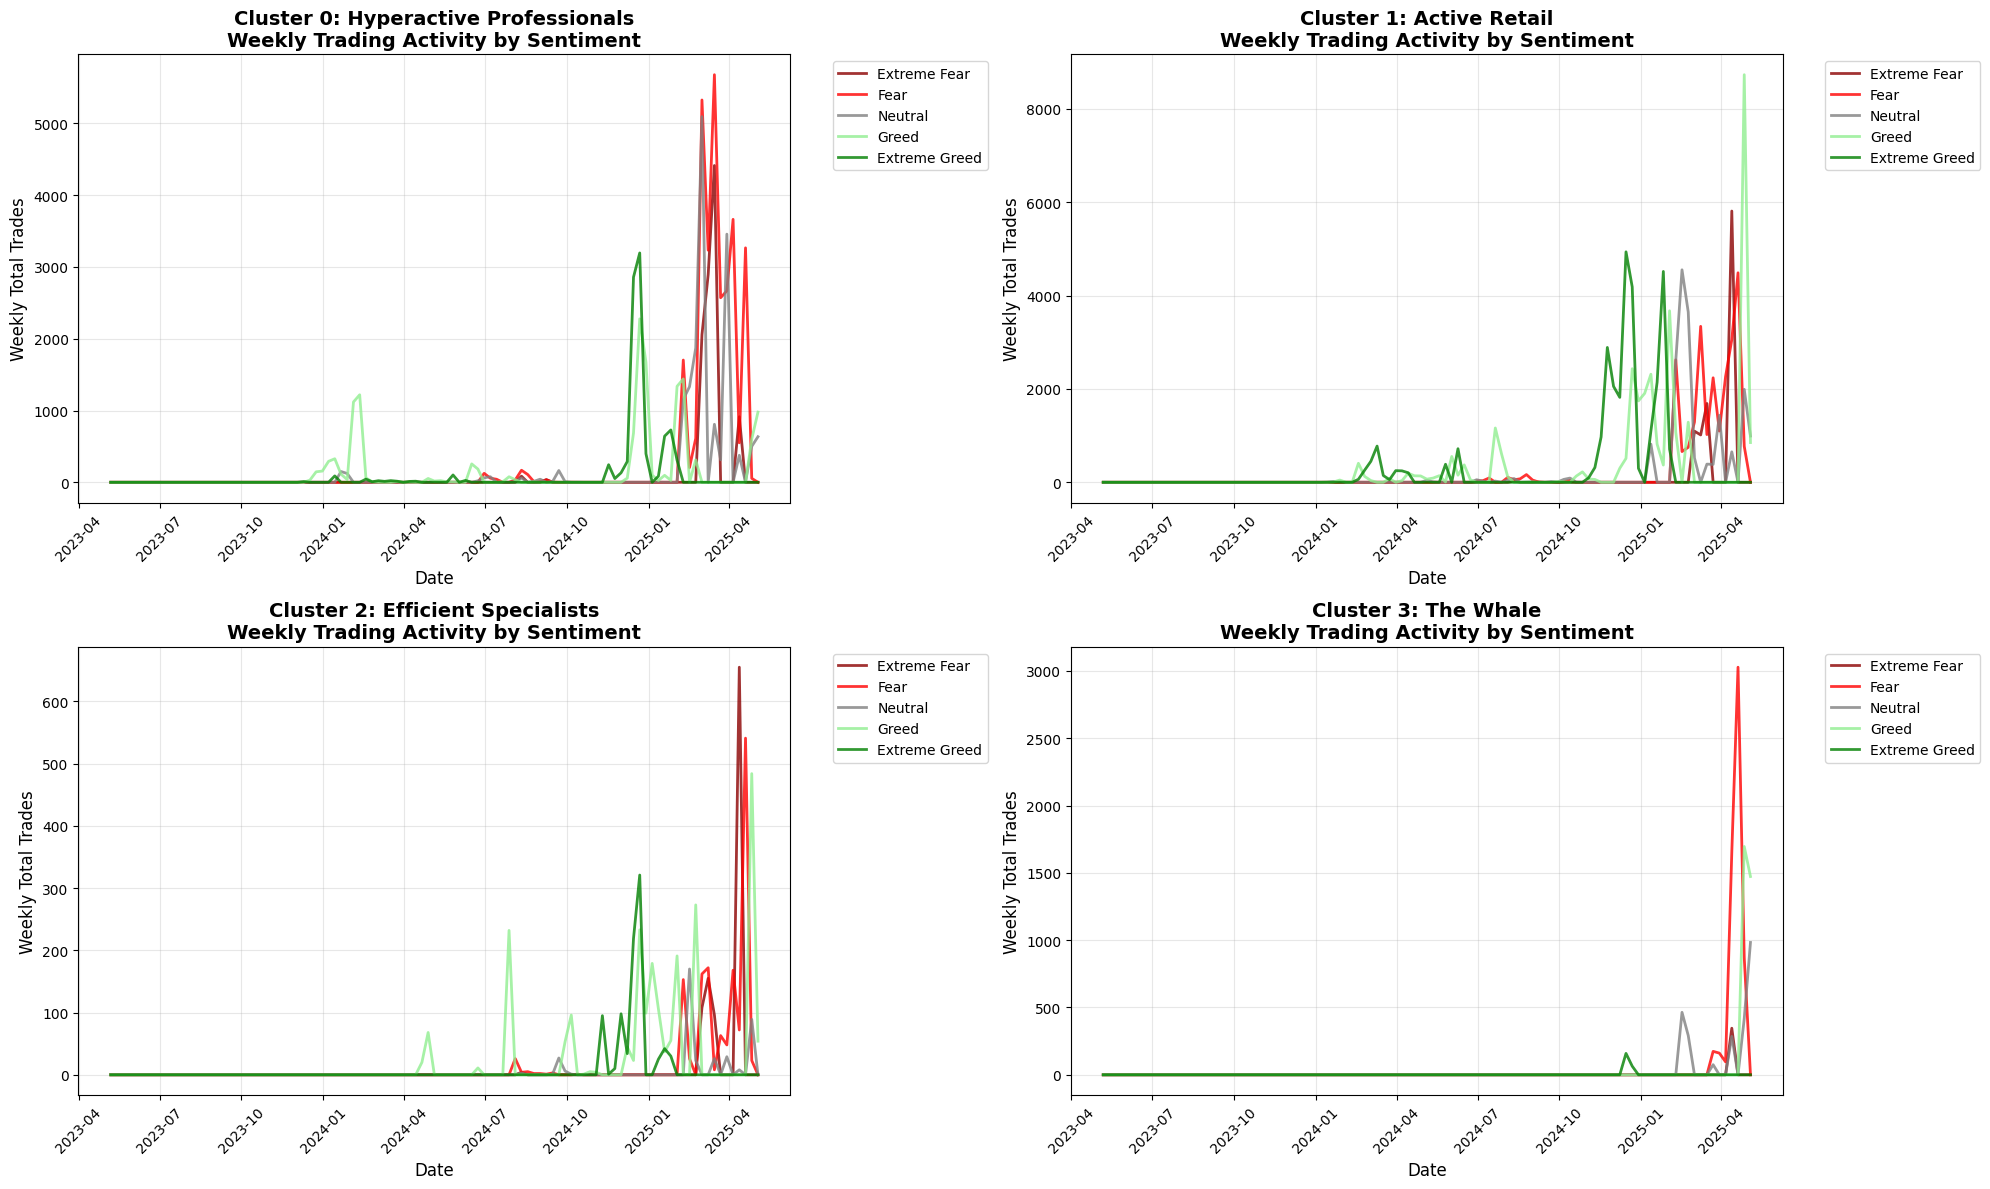

In [ ]:
#Temporal Analysis - Trading Activity by Cluster and Sentiment Over Time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Aggregate total trades over time by cluster and sentiment
trades_over_time = combined_final_df.groupby(['date', 'Cluster', 'classification'])['Daily_Trades'].sum().reset_index()

# 2. Create weekly aggregation for smoother visualization
trades_over_time['date'] = pd.to_datetime(trades_over_time['date'])
trades_over_time.set_index('date', inplace=True)

# Pivot table for easier plotting
pivot_trades = trades_over_time.pivot_table(
    index='date', 
    columns=['Cluster', 'classification'], 
    values='Daily_Trades', 
    fill_value=0
)

# Resample to weekly data to reduce noise
weekly_trades = pivot_trades.resample('W').sum()

# 3. Create the multi-panel plot
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
clusters = [0, 1, 2, 3]
cluster_names = ['Hyperactive Professionals', 'Active Retail', 'Efficient Specialists', 'The Whale']
sentiments = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
colors = ['darkred', 'red', 'gray', 'lightgreen', 'green']

for i, cluster in enumerate(clusters):
    ax = axes[i//2, i%2]
    
    for sentiment, color in zip(sentiments, colors):
        if (cluster, sentiment) in weekly_trades.columns:
            data = weekly_trades[(cluster, sentiment)]
            ax.plot(data.index, data.values, label=sentiment, color=color, linewidth=2, alpha=0.8)
    
    ax.set_title(f'Cluster {cluster}: {cluster_names[i]}\nWeekly Trading Activity by Sentiment', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Weekly Total Trades', fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


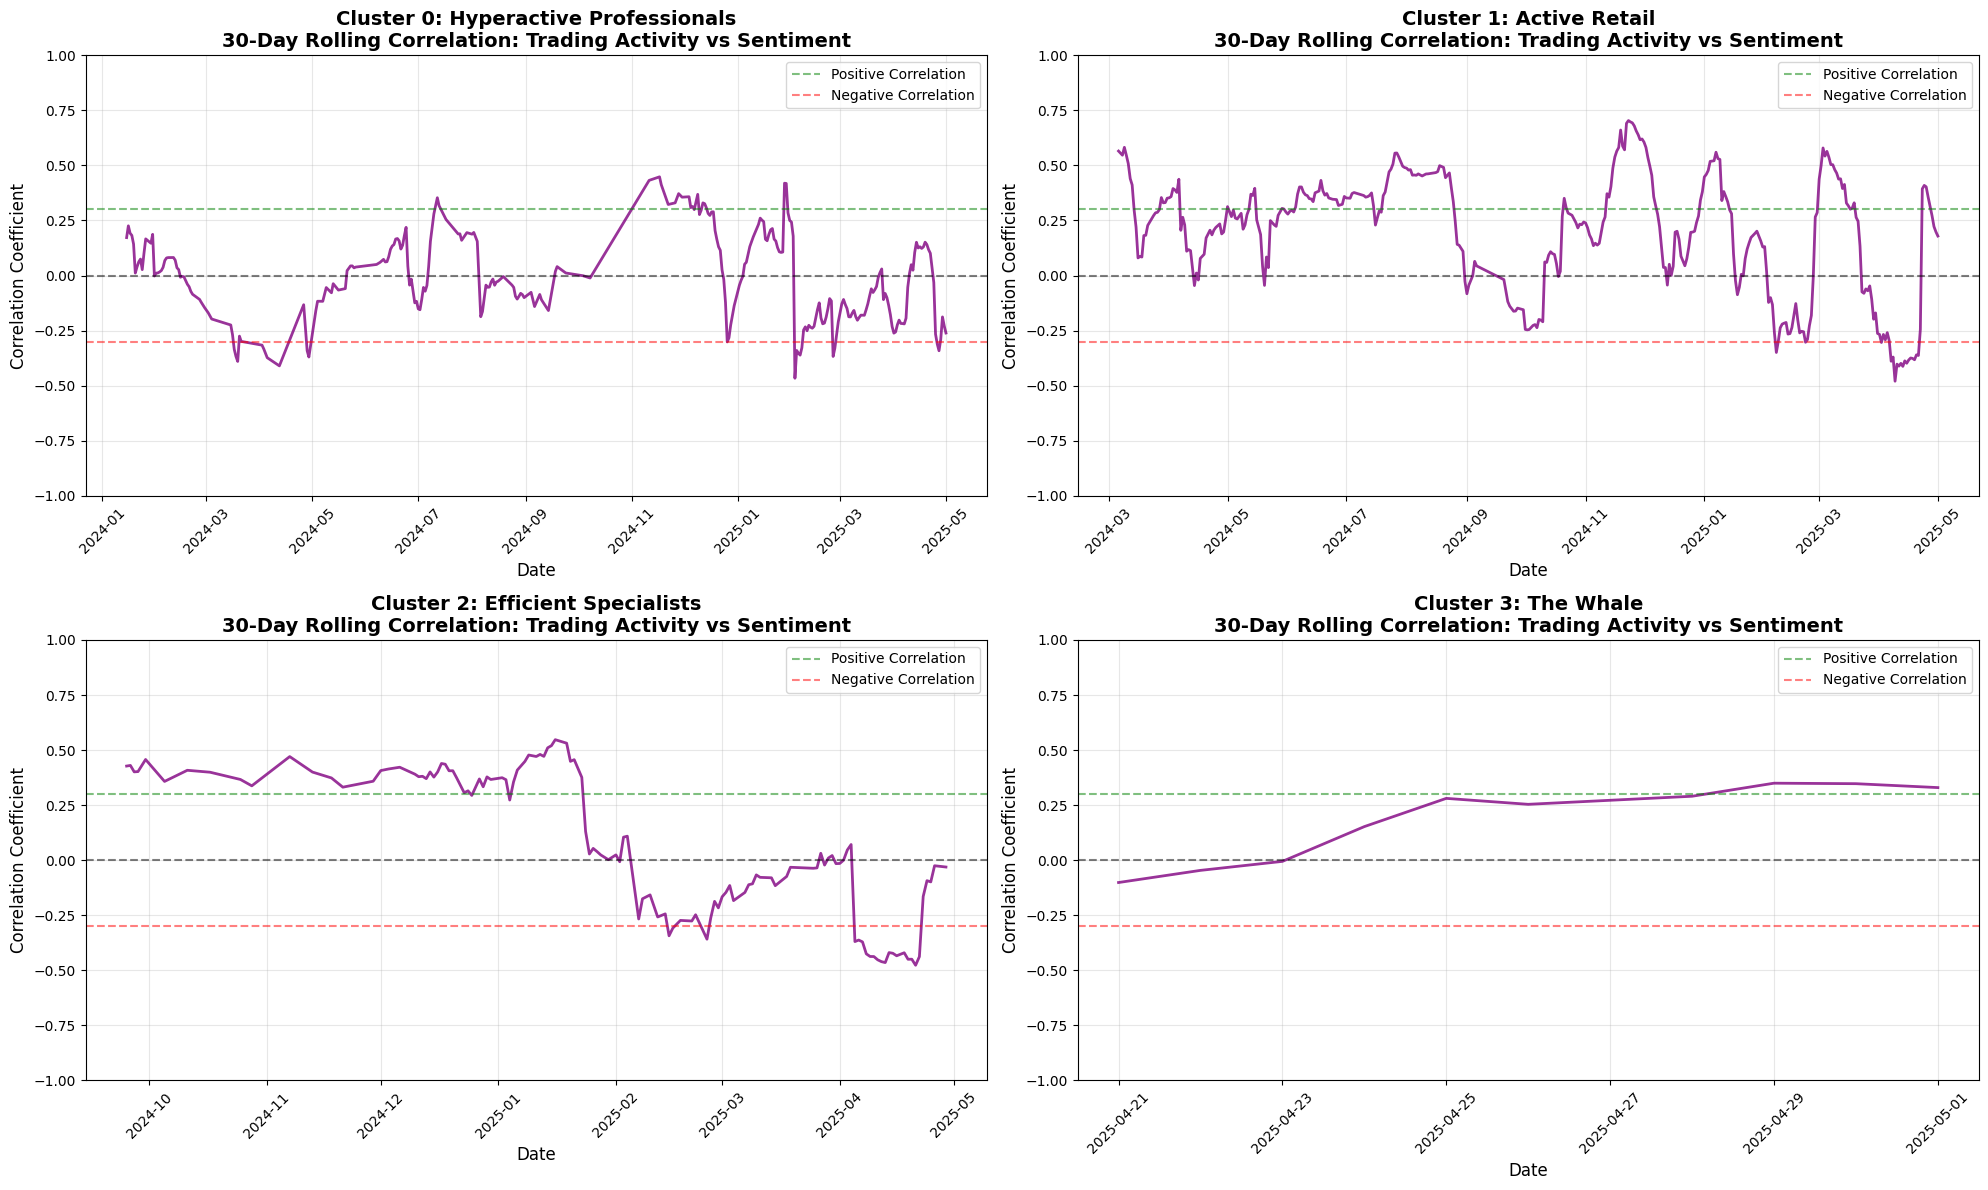

In [ ]:
# Create rolling 30-day correlation
rolling_window = 30
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

for i, cluster in enumerate(clusters):
    ax = axes[i//2, i%2]
    
    # Get daily sentiment values and total daily trades for this cluster
    cluster_daily = combined_final_df[combined_final_df['Cluster'] == cluster].groupby('date').agg({
        'Daily_Trades': 'sum',
        'value': 'first'  # Sentiment value is same for all traders on same date
    })
    
    # Calculate rolling correlation
    rolling_corr = cluster_daily['Daily_Trades'].rolling(window=rolling_window).corr(cluster_daily['value'])
    
    ax.plot(rolling_corr.index, rolling_corr.values, linewidth=2, color='purple', alpha=0.8)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.axhline(y=0.3, color='green', linestyle='--', alpha=0.5, label='Positive Correlation')
    ax.axhline(y=-0.3, color='red', linestyle='--', alpha=0.5, label='Negative Correlation')
    
    ax.set_title(f'Cluster {cluster}: {cluster_names[i]}\n30-Day Rolling Correlation: Trading Activity vs Sentiment', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Correlation Coefficient', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(-1, 1)

plt.tight_layout()
plt.show()
